In [1]:
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
LOGS_FOLDER = "/mnt/c/Users/Diego Piccinotti/Documents/Università/alphazero_singleplayer/logs/RaceStrategy-v2/results/"
DATA_FOLDER = "2020-11-04_17-27-59_50000b"
directory = os.path.join(LOGS_FOLDER, DATA_FOLDER)
dfs = defaultdict(dict)
for entry in tqdm(os.scandir(directory)):
    if entry.is_file:
        filename = entry.name
        filename = filename[:-4]
        tokens = filename.split('_')
        timestamp = tokens.pop(0)
        df = pd.read_csv(entry.path)
        dfs[tokens[0] + "_" + timestamp][tokens[2]] = df
        dfs[tokens[0] + "_" + timestamp]['year'] = tokens[1]

40it [00:00, 186.12it/s]


In [3]:
database = pd.DataFrame(columns=['race', 'year', 'lap', 'driver', 'lap_time', 'cumulative_time', 'influence', 'position', 'id'])
index = 0
count = 0
for i, race_id in enumerate(tqdm(dfs)):
    tokens = race_id.split('_')
    timestamp = tokens[1]
    race = tokens[0]
    year = dfs[race_id]['year']

    lap_times = dfs[race_id]['laptimes']
    influences = dfs[race_id]['lapinfluences']
    positions = dfs[race_id]['positions']
    race_times = dfs[race_id]['racetimes']
    
    columns = list(lap_times.columns)
    columns.remove('lap')

    for lap in lap_times.lap.unique():
        lap_time_single_lap = lap_times.loc[lap_times['lap'] == lap]
        influences_single_lap = influences.loc[influences['lap'] == lap]
        positions_single_lap = positions.loc[positions['lap'] == lap]
        race_times_single_lap = race_times.loc[race_times['lap'] == lap]
        for col in columns:
            index += 1
            new_df = {}
            new_df['id'] = [timestamp]
            new_df['race'] = [race]
            new_df['year'] = [year]
            new_df['lap'] = [lap]
            new_df['driver'] = [col]
            new_df['lap_time'] = lap_time_single_lap[col].values
            new_df['influence'] = influences_single_lap[col].values
            new_df['cumulative_time'] = race_times_single_lap[col].values
            new_df['position'] = positions_single_lap[col].values
            new_df = pd.DataFrame(new_df, index=[index])
            database = pd.concat([database, new_df])
    if i == 19:
        break

database.describe()


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


,lap_time,cumulative_time
count,11400.000000,11400.000000
mean,93.328510,2720.459813
std,4.073106,1535.586644
min,87.240000,97.052000
25%,91.227000,1393.225000
50%,92.500000,2734.716000
75%,93.898500,4043.777000
max,124.460000,5870.491000


In [4]:
database

,race,year,lap,driver,lap_time,cumulative_time,influence,position,id
1,Melbourne,2017,1,VAN,104.962,104.962,none,14,1604513668335
2,Melbourne,2017,1,RIC,104.162,104.162,none,13,1604513668335
3,Melbourne,2017,1,VET,98.577,98.577,none,2,1604513668335
4,Melbourne,2017,1,RAI,99.377,99.377,none,4,1604513668335
5,Melbourne,2017,1,GRO,101.362,101.362,none,6,1604513668335
...,...,...,...,...,...,...,...,...,...
11396,Melbourne,2017,57,VER,90.028,5227.790,none,5,1604530513413
11397,Melbourne,2017,57,HAM,90.383,5191.313,none,1,1604530513413
11398,Melbourne,2017,57,SAI,93.438,5317.209,none,12,1604530513413
11399,Melbourne,2017,57,BOT,90.383,5191.713,none,2,1604530513413


<AxesSubplot:xlabel='lap', ylabel='lap_time'>

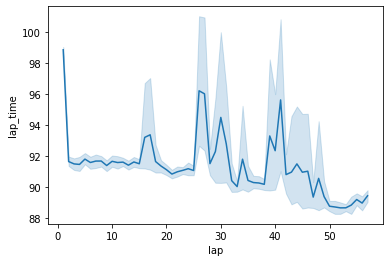

In [5]:
vettel = database.loc[(database['driver'] == 'VET') & (database['race'] == 'Melbourne')]
vettel = vettel.sort_values('lap')
pits = []
for index, row in vettel.iterrows():
    if 'pitinlap' in row['influence']:
        pits.append(row['lap'])
sns.lineplot(data=vettel, y='lap_time', x='lap')
#plt.ylim([85, 95])

<AxesSubplot:xlabel='lap', ylabel='lap_time'>

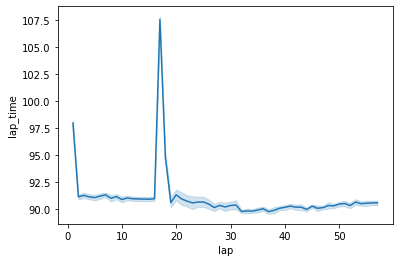

In [24]:
hamilton = database.loc[(database['driver'] == 'HAM') & (database['race'] == 'Melbourne')]
hamilton = hamilton.sort_values('lap')
pits = []
for index, row in hamilton.iterrows():
    if 'pitinlap' in row['influence']:
        pits.append(row['lap'])
sns.lineplot(data=hamilton, y='lap_time', x='lap')
#plt.ylim([85, 95])

In [6]:
len(pits)/len(vettel['id'].unique())

2.3

In [20]:
vettel['position'] = vettel['position'].astype(int)
vettel['cumulative_time'] = vettel['cumulative_time'].astype(int)
vettel[vettel['lap'] == vettel['lap'].max()].describe()

,lap_time,cumulative_time,position
count,20.000000,20.000000,20.000000
mean,90.009900,5200.550000,3.350000
std,0.725731,14.572776,1.268028
min,88.809000,5179.000000,2.000000
25%,89.496000,5190.000000,2.000000
50%,89.995500,5197.500000,3.000000
75%,90.433000,5209.500000,4.000000
max,91.454000,5228.000000,6.000000


In [25]:
hamilton['position'] = hamilton['position'].astype(int)
hamilton['cumulative_time'] = hamilton['cumulative_time'].astype(int)
hamilton[hamilton['lap'] == hamilton['lap'].max()].describe()

,lap_time,cumulative_time,position
count,20.000000,20.000000,20.0
mean,90.569250,5187.400000,1.0
std,0.477238,7.604708,0.0
min,89.797000,5175.000000,1.0
25%,90.167500,5183.000000,1.0
50%,90.666000,5186.500000,1.0
75%,90.894750,5194.000000,1.0
max,91.454000,5203.000000,1.0


In [44]:
ham = hamilton[hamilton['lap'] == hamilton['lap'].max()]
vet = vettel[vettel['lap'] == vettel['lap'].max()]
ham['id'] = ham['id'].astype(int)
vet['id'] = ham['id'].astype(int)
ham.sort_values('id')
vet.sort_values('id') 
delta = vet['cumulative_time'].values - ham['cumulative_time'].values

print("Delta {} +- {}".format(np.mean(delta), np.std(delta)))

Delta 19.9 +- 17.924564150907546


In [16]:
import numpy as np
import matplotlib.pyplot as plt
online_scores = np.load('../data/2020-10-14_18-21/game/trpo_2_32_0.001/models/2020-10-14_18-21/online_scores.npy')
offline_scores = np.load('../data/2020-10-14_18-21/game/trpo_2_32_0.001/models/2020-10-14_18-21/offline_scores.npy', allow_pickle=True)
print(offline_scores)

[list([7.89640374307387, 0.0]) 3.08 3.02 3.34 0.0
 list([12.57562964395507, 0.0]) 17.92 1.72 21.98 0.0
 list([12.998051882745498, 0.0]) 23.64 1.08 20.86 0.0
 list([13.195839795640815, 0.0]) 17.04 1.02 27.82 0.0
 list([13.216797443994983, 0.0]) 14.54 1.08 29.9 0.0]


<AxesSubplot:>

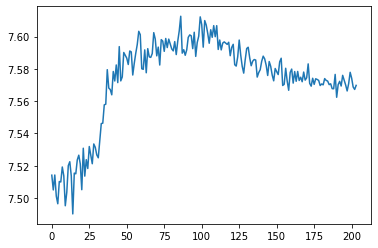

In [13]:
sns.lineplot(data=online_scores)

In [11]:
sns.lineplot(data=online_scores[:, 0])
plt.title("Return per epoch")

import numpy as np

lower_bound = online_scores[:, 0] - online_scores[:, 1]
upper_bound = online_scores[:, 0] + online_scores[:, 1]

plt.fill_between(np.arange(200) , lower_bound, upper_bound, alpha=.3)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed